The Planetary Variable Land Surface Temperature (LST) through Planet’s Subscriptions APIs offers a high-quality, reliable dataset to better model weather systems and improve decision-making. In this article, learn about the unique benefits of using the Subscriptions APIs to monitor and deliver Land Surface Temperature Planetary Variables data, walk through a typical workflow, and discover additional resources.

## Land Surface Temperature in Subscriptions API

Land Surface Temperature provides twice-daily measurements of land surface temperature with high spatial resolution and consistency. LST data eliminates the need for maintaining large networks of physical sensors, reduces the impact of cloud cover on measurements, and enables a more accurate reflection of ground conditions across large areas. This data is generated using passive microwave data, enabling cloud-free measurements. The Land Surface Temperature data serves diverse use cases, such as:

* enhancing weather models with consistent temperature measurements
* improving urban heat stress monitoring
* refining agricultural models
* monitoring drought conditions


## Workflow: monitoring temperature over an agricultural area

### Setting up your script and connecting with Planet services

To execute the code in this example, you will need:

- A [Planet API key](https://developers.planet.com/quickstart/apis/#find-your-api-key)
- Access to the LST-AMSR2_V1.0_100 product for the provided field geometry
- Configured credentials for storage of the results to cloud storage (Google Cloud Platform, Amazon Web Services, Microsoft Azure, or Oracle Collaboration Suite)

The code examples in this workflow are written for Python 3.8 or greater (python>=3.8). Aside from the built-in Python libraries, the following packages are required:
```
- keyring
- matplotlib
- pandas
- rasterio
- requests
- rioxarray
```

In [1]:
# Python builtins
import base64
from getpass import getpass
from io import StringIO
import json
import os

# External requirements
import keyring
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
import requests
from requests.auth import HTTPBasicAuth
import rioxarray as rx


In this example, the [keyring](https://github.com/jaraco/keyring) package will be used to store/retrieve your [Planet API key](https://developers.planet.com/quickstart/apis/#find-your-api-key). You are prompted to enter the key once. Then it is securely stored on the system’s keyring.

> Anyone with access to this system’s user account can also access the keyring, so **only enter your Planet API key on a system’s user account that only you can use**.


In [2]:
# Authentication
update = False  # Set to True if you want to update the credentials in the system's keyring

if keyring.get_password("planet", "PL_API_KEY") is None or update:
    keyring.set_password("planet", "PL_API_KEY", getpass("Planet API Key: "))
else: 
    print("Using stored api key")

PL_API_KEY = keyring.get_password("planet", "PL_API_KEY")


Using stored api key


Next, confirm your API key by making a call to Planet services. You should receive back a `<Response [200]>`.

In [3]:
# Planet's Subscriptions API base URL for making restFUL requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

auth = HTTPBasicAuth(PL_API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
print(response)


<Response [200]>


### Creating a Planetary Variables Subscription with the Subscriptions API

To create a subscription, provide a JSON request object that details the subscription parameters, including:

- subscription name (required)
- Planetary Variable source type (required)
- data product id (required)
- subscription location in GeoJSON format (required)
- start date for the data subscription (required)
- end date for the data subscription (optional)

For further details on available parameters, see [Create a Planetary Variables Subscription](https://developers.planet.com/docs/subscriptions/pvs-subs/#create-a-planetary-variables-subscription) in [Subscribing to Planetary Variables](https://developers.planet.com/docs/subscriptions/pvs-subs/).

#### Create your JSON subscription description object

This first example creates a subscription for 5 years of 100m resolution LST data over the agricultural area of Red Cloud, Nebraska.

Subscriptions can be created with or without a [delivery](https://developers.planet.com/docs/subscriptions/delivery/) parameter, which specifies a storage location to deliver raster data. For this first analysis we do not require raster assets, so the delivery parameter has been omitted to create a [metadata-only subscription](https://developers.planet.com/docs/subscriptions/pvs-subs/#metadata-only-subscriptions).

To confirm if the provided geometry fits into a specific area of access (AOA) see the following [code example](https://developers.planet.com/docs/subscriptions/api-mechanics/#permissions).


In [4]:
# Create a new subscription JSON object
timeseries_payload = {
    "name": "Red Cloud, NE - 5 years - LST-AMSR2_V1.0_100",
    "source": {
        "type": "land_surface_temperature",
        "parameters": {
            "id": "LST-AMSR2_V1.0_100",
            "start_time": "2018-05-01T00:00:00Z",
            "end_time": "2023-05-01T00:00:00Z",
            "geometry": {
                "coordinates": [[[-98.74073, 40.33321],
                                 [-98.74073, 39.99023],
                                 [-98.21980, 39.99023],
                                 [-98.21980, 40.33321],
                                 [-98.74073, 40.33321]]],
                "type": "Polygon"
            }
        }
    }
}


#### Create a subscription using your JSON description object

These details are sent to the Subscriptions API to create a new subscription and receive its unique subscription ID.


In [5]:
def create_subscription(subscription_payload, auth, headers):
    try:
        response = requests.post(BASE_URL, json=subscription_payload, auth=auth, headers=headers)
        response.raise_for_status()  # raises an error if the request was malformed
    except requests.exceptions.HTTPError:
        print(f"Request failed with {response.text}")  # show the reason why the request failed
    else:
        response_json = response.json()
        subscription_id = response_json["id"]
        print(f"Successful request with {subscription_id=}")
        return subscription_id

# set content type to json
headers = {'content-type': 'application/json'}

# create a subscription
timeseries_subscription_id = create_subscription(timeseries_payload, auth, headers)
print(timeseries_subscription_id)

Successful request with subscription_id='8de4b79a-959d-4787-96b5-a34afd59632d'
8de4b79a-959d-4787-96b5-a34afd59632d


#### Confirm the subscription status

To retrieve the status of the subscription, request the subscription endpoint with a `GET` request. Once it is in `running` or `completed` state, the delivery should either be in progress or completed, respectively. A subscription with an end date in the future remains in `running` state until the `end_date` is in the past. See [Status descriptions](https://developers.planet.com/docs/subscriptions/#subscription-status) for the complete overview of possible status descriptions.

While you can use the data as it becomes available to start building your analysis, running the subscription may take a while depending on factors such as the size of your AOI and the time range.


In [9]:
def get_subscription_status(subscription_id, auth):
    subscription_url = f"{BASE_URL}/{subscription_id}"
    subscription_status = requests.get(subscription_url, auth=auth).json()['status']
    return subscription_status

status = get_subscription_status(timeseries_subscription_id, auth)
print(status)


running


### Retrieving and analyzing the subscription data

The metadata results generated for this subscription can be retrieved directly in CSV format. Use the Pandas library to read this into a dataframe to perform further analysis and to create a time series visualization.

Data that is invalid for analysis, for example due to having limited coverage on a certain day, is filtered out of the dataframe. For more information on data validity, see [Metadata Results](https://developers.planet.com/docs/subscriptions/pvs-subs/#metadata-results-time-series).


In [46]:
# Retrieve the resulting data in CSV format
results_csv = requests.get(f"{BASE_URL}/{timeseries_subscription_id}/results?format=csv", auth=auth)

# Read CSV Data into a Pandas dataframe
csv_text = StringIO(results_csv.text)
df = pd.read_csv(csv_text, parse_dates=["item_datetime", "local_solar_time"], index_col="local_solar_time")

# Filter by valid data only
df = df[df["lst.band-1.valid_percent"].notnull()]
df = df[df["lst.band-1.valid_percent"] > 0]
df = df[df["status"] != "QUEUED"]

print(df.head())


                                                       id  \
local_solar_time                                            
2018-05-02 01:30:00  5ad152e1-32e3-41e4-bfec-e2da33a8a766   
2018-05-02 13:30:00  7c0de214-f58e-4464-942b-306653653e10   
2018-05-03 01:30:00  7b1ae739-599f-41e0-ae42-ea9a4ba91aab   
2018-05-03 13:30:00  80858f82-109e-410c-b813-cf2f8c778d62   
2018-05-04 01:30:00  9f2c3b30-9f0e-4672-b67f-232423a99f5a   

                                item_datetime   status  \
local_solar_time                                         
2018-05-02 01:30:00 2018-05-02 08:30:00+00:00  SUCCESS   
2018-05-02 13:30:00 2018-05-02 20:30:00+00:00  SUCCESS   
2018-05-03 01:30:00 2018-05-03 08:30:00+00:00  SUCCESS   
2018-05-03 13:30:00 2018-05-03 20:30:00+00:00  SUCCESS   
2018-05-04 01:30:00 2018-05-04 08:30:00+00:00  SUCCESS   

                                         created                      updated  \
local_solar_time                                                                
201

Now, you are ready to analyze the average temperature of the agricultural region of Red Cloud, NE, over time. Two time series plots are created: one for nighttime observations (captured at 01:30 solar time) and one for daytime observations (captured at 13:30 solar time).


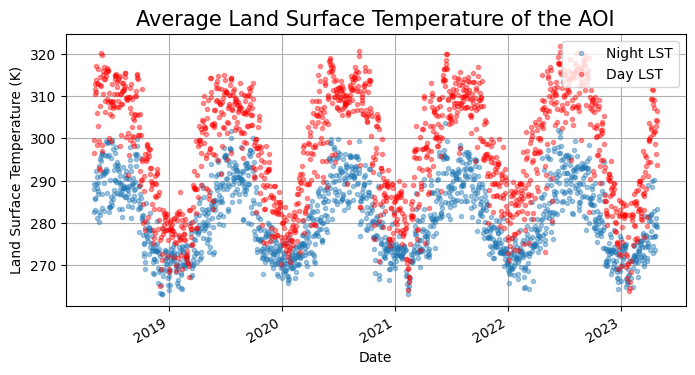

In [47]:
# Plot the Land Surface Temperature time-series for nighttime observations
df.between_time("1:15", "1:45")["lst.band-1.mean"].plot(
    grid=True, style=".", alpha=0.4, label="Night LST", figsize=(8, 4)
)

# Plot the Land Surface Temperature time-series for daytime observations
df.between_time("13:15", "13:45")["lst.band-1.mean"].plot(
    grid=True, style="r.", alpha=0.4, label="Day LST", figsize=(8, 4)
)

# Extra information for the visualization
plt.ylabel("Land Surface Temperature (K)", size = 10)
plt.xlabel("Date", size = 10)
plt.title("Average Land Surface Temperature of the AOI", size = 15)
plt.legend()

# Display the visualization
plt.show()


### Delivering results as a raster map

In addition to providing metadata over an Area of Interest, you can also configure the delivery of raster results directly to a cloud storage location. 

The following delivery options are currently supported:

1. `google_cloud_storage`
2. `amazon_s3`
3. `azure_blob_storage`
4. `oracle_cloud_storage`

See the [supported delivery options](https://developers.planet.com/docs/subscriptions/delivery/#supported-delivery-options) or the [API reference](https://developers.planet.com/docs/subscriptions/reference/#tag/subscriptions/operation/createSubscription) and open the delivery options to review the options for each delivery type. This example uses Google cloud storage.

#### Configuring the delivery options

To deliver results directly to a Google Cloud storage bucket, specify the delivery location and provide your authentication credentials.

See the [Google Cloud documentation](https://cloud.google.com/iam/docs/keys-create-delete#iam-service-account-keys-create-console) on how to create a service account key. When using AWS, Azure or OCS, use the appropriate credentials for those platforms.


In [14]:
BUCKET_NAME = "lst_subscriptions_api"
GOOGLE_APPLICATION_CREDENTIALS = "key.json"   # path to the google application credentials key

if not os.path.exists(GOOGLE_APPLICATION_CREDENTIALS):
    credentials_path = os.path.abspath(GOOGLE_APPLICATION_CREDENTIALS)
    print(f"No google application credentials found at: {credentials_path}")

# Credentials are expected in base64 format -the following reads the json key as bytes, 
# applies the base64 encoding and decodes back to a python str
with open(GOOGLE_APPLICATION_CREDENTIALS, "rb") as f:
    gcs_credentials_base64 = base64.b64encode(f.read()).decode()

delivery_options = {
        "type": "google_cloud_storage",
        "parameters": {
            "bucket": BUCKET_NAME,
            "credentials": gcs_credentials_base64
        }
    }

#### Create a subscription with delivery configured

Now create a new subscription for three days worth of data over the Red Cloud region. 


In [15]:
raster_payload = {
    "name": "Red Cloud, NE - 3 days - LST-AMSR2_V1.0_100",
    "source": {
        "type": "land_surface_temperature",
        "parameters": {
            "id": "LST-AMSR2_V1.0_100",
            "start_time": "2022-09-18T00:00:00Z",
            "end_time": "2022-09-20T00:00:00Z",
            "geometry": {
                "coordinates": [[[-98.74073, 40.33321],
                                 [-98.74073, 39.99023],
                                 [-98.21980, 39.99023],
                                 [-98.21980, 40.33321],
                                 [-98.74073, 40.33321]]],
                "type": "Polygon"
            }
        }
    },
    "delivery": delivery_options
}

raster_subscription_id = create_subscription(raster_payload, auth, headers)
print(raster_subscription_id)


Successful request with subscription_id='00fa98bb-6aab-4f63-a225-01888c4f0bb2'
00fa98bb-6aab-4f63-a225-01888c4f0bb2


Results are generated and stored in the configured cloud storage option as GeoTIFF files. The subscription status field changes to `completed` when all files have been delivered.


In [38]:
status = get_subscription_status(raster_subscription_id, auth=auth)
print(status)


running


#### Plot the GeoTIFF

The `rioxarray` extension to [rasterio](https://rasterio.readthedocs.io/en/latest/installation.html) can be used to open and map the delivered GeoTIFF files directly from their cloud storage location. 

There are many options for configuring access through the different cloud storage services. Rasterio uses GDAL under the hood and the configuration options for [network based file systems](https://gdal.org/user/virtual_file_systems.html#network-based-file-systems) notably:

- [Amazon Web Service](https://gdal.org/user/virtual_file_systems.html#vsis3-aws-s3-files)
- [Google Cloud](https://gdal.org/user/virtual_file_systems.html#vsigs-google-cloud-storage-files)
- [Microsoft Azure](https://gdal.org/user/virtual_file_systems.html#vsiaz-streaming-microsoft-azure-blob-files-streaming)

In the following example, the data is read directly from the Google Cloud Storage bucket configured previously to visualize the Land Surface Temperature 100m resolution map over Red Cloud on the 18th of September, 2022.


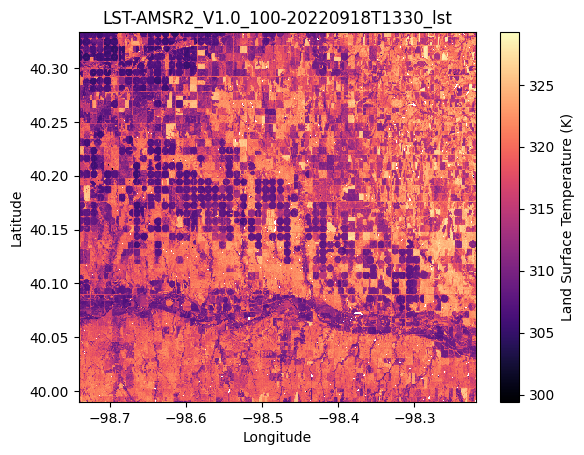

In [40]:
# Set the filepath to the 18 September 2022 GeoTIFF asset
lst_file_location = f"gs://{BUCKET_NAME}/{raster_subscription_id}/2022/09/18/LST-AMSR2_V1.0_100-20220918T1330_lst.tiff"

# Use the Google Application credentials to allow access to the storage location
with rasterio.env.Env(GOOGLE_APPLICATION_CREDENTIALS=GOOGLE_APPLICATION_CREDENTIALS):
    lst_data = rx.open_rasterio(lst_file_location, mask_and_scale=True, band_as_variable=True)

    lst_data = lst_data.rename({"x":"Longitude","y":"Latitude"})
    lst_data = lst_data.rename_vars({
        "band_1":"Land Surface Temperature (K)",
        "band_2":"Masked LST values (K)",
    })
    lst_data["Land Surface Temperature (K)"].plot(cmap="magma")

    plt.title("LST-AMSR2_V1.0_100-20220918T1330_lst")
    plt.show()


### Learning Resources

Get the details in the [Land Surface Temperature Technical Specification](https://assets.planet.com/docs/Planet_Land_Surface_Temperature_Product_specifications.pdf). [Get Started with Planet APIs](https://developers.planet.com/docs/apis/subscriptions/api-mechanics/). Find a collection of guides and tutorials on [Planet University](https://university.planet.com). Also checkout Planet notebooks on GitHub, such as the Subscriptions tutorials: [subscriptions_api_tutorial](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/subscriptions_api_tutorial/).